In [1]:
import numpy as np
import os, re
import json
import h5py as h5
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
def DataLoader(file_name, nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        #uncomment below to add noise like caloflows does
        #data_flat +=np.random.uniform(0,1e-3,size=data_flat.shape)
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat,energy_layer).filled(0)
        return energy_layer,data_flat


    flat_energy , flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy ,shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy,energy),-1)
        flat_shower = np.concatenate((flat_shower,shower),-1)
        
    return e,flat_energy,flat_shower


N = 200000 # number of data points to load

file_path = '/clusterfs/ml4hep/haoxing_du/sampling_gamma_corr.hdf5'
energy, energy_layer, energy_voxel = DataLoader(file_path, N)
print(energy.shape, energy_layer.shape, energy_voxel.shape)

(200000, 1) (200000, 3) (200000, 504)


In [3]:
layer0 = np.array([x[0] for x in energy_layer])
layer1 = np.array([x[1] for x in energy_layer])
layer2 = np.array([x[2] for x in energy_layer])

In [4]:
# Let's look at a random data point
i = np.random.randint(1000)

print(f"True particle energy: {energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {layer0[i]} MeV")
print(f"Layer 1 energy: {layer1[i]} MeV")
print(f"Layer 2 energy: {layer2[i]} MeV")
print(f"Difference (true - total): {energy[i][0]*1000-layer0[i]-layer1[i]-layer2[i]} MeV")

True particle energy: 65729.52270507812 MeV
Layer 0 energy: 2637.82373046875 MeV
Layer 1 energy: 7171.916015625 MeV
Layer 2 energy: 248.19606018066406 MeV
Difference (true - total): 55671.58689880371 MeV


In [ ]:
# There seem to be 701 events where the amount of energy deposited
# in all the layers exceed the incoming energy
len(u0[u0[:] > 1])

In [81]:
def preprocess_log(N, layer0, layer1, layer2, energy):
    energy_layer = np.stack([layer0, layer1, layer2], -1)
    all_energies = np.concatenate([energy_layer, energy*1000],-1)
    all_energies += 1e-10 # in case there are 0s and taking log of 0 is an issue
    return np.log10(all_energies/10000)

def preprocess_caloflow(N, layer0, layer1, layer2, energy, alpha):
    #print(N, layer0, layer1, layer2, energy, alpha)
    e_tot = energy.reshape(N,)
    u0 = (layer0 + layer1 + layer2)/(e_tot*1000)
    u0 = np.array([min(1.0, i) for i in u0]) # make sure u0 <= 1
    u1 = layer0 / (layer0 + layer1 + layer2)
    u2 = layer1 / (layer1 + layer2)

    x0 = alpha + (1 - 2*alpha)*u0
    x1 = alpha + (1 - 2*alpha)*u1
    x2 = alpha + (1 - 2*alpha)*u2

    v0 = np.log(x0/(1-x0))
    v1 = np.log(x1/(1-x1))
    v2 = np.log(x2/(1-x2))

    e_tot = e_tot * 1000
    e_tot += 1e-10
    e_tot_log = np.log10(e_tot/10000)

    return np.stack([v0, v1, v2, e_tot_log], -1)

In [13]:
data_log = preprocess_log(N, layer0, layer1, layer2, energy)
alpha = 1e-6
data_caloflow = preprocess_caloflow(N, layer0, layer1, layer2, energy, alpha)

In [16]:
# DEFUNCT - standard scaler
def preprocess_stdsclr(N, layer0, layer1, layer2, energy):
    from sklearn.preprocessing import StandardScaler
    energy_scaled = np.log10(energy/10)
    e = energy.reshape(N,)
    u0 = (layer0 + layer1 + layer2)/(e*1000)
    u0 = np.array([min(1.0, i) for i in u0]) # make sure u0 <= 1
    u1 = layer0 / (layer0 + layer1 + layer2)
    u2 = layer1 / (layer1 + layer2)
    
    scaler_data = StandardScaler()
    scaler_cond = StandardScaler()
    data_only = np.stack([u0, u1, u2], -1)
    scaler_data.fit(data_only)
    scaler_cond.fit(energy_scaled)
    data = scaler_data.transform(data_only)
    cond = scaler_cond.transform(energy_scaled)
    
    return np.concatenate([data, cond], -1), scaler_data, scaler_cond

N = 200000
data_train, scaler_data, scaler_cond = preprocess_stdsclr(N, layer0, layer1, layer2, energy)

(array([2.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00, 4.00000e+00,
        7.00000e+00, 1.00000e+01, 1.20000e+01, 2.50000e+01, 2.40000e+01,
        4.20000e+01, 8.70000e+01, 1.59000e+02, 3.12000e+02, 6.58000e+02,
        1.50200e+03, 4.61000e+03, 2.01070e+04, 1.07529e+05, 6.49040e+04,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
         1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
         2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
         3.75510204,  3.93877551,  4.12244898,  4.30612245,  4

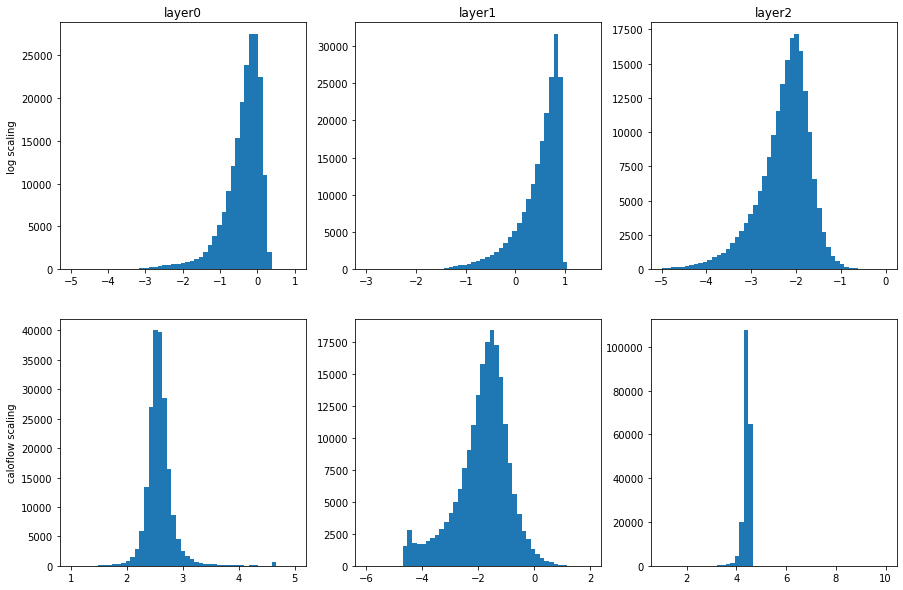

In [70]:
# Visualize different scalings
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.hist(data_log[:,0], bins=np.linspace(-5,1,50))
plt.ylabel("log scaling")
plt.title("layer0")
plt.subplot(232)
plt.hist(data_log[:,1], bins=np.linspace(-3,1.5,50))
plt.title("layer1")
plt.subplot(233)
plt.hist(data_log[:,2], bins=np.linspace(-5,0,50))
plt.title("layer2")
plt.subplot(234)
plt.hist(data_caloflow[:,0], bins=np.linspace(1,5,50))
plt.ylabel("caloflow scaling")
plt.subplot(235)
plt.hist(data_caloflow[:,1], bins=np.linspace(-6,2,50))
plt.subplot(236)
plt.hist(data_caloflow[:,2], bins=np.linspace(1,10,50))

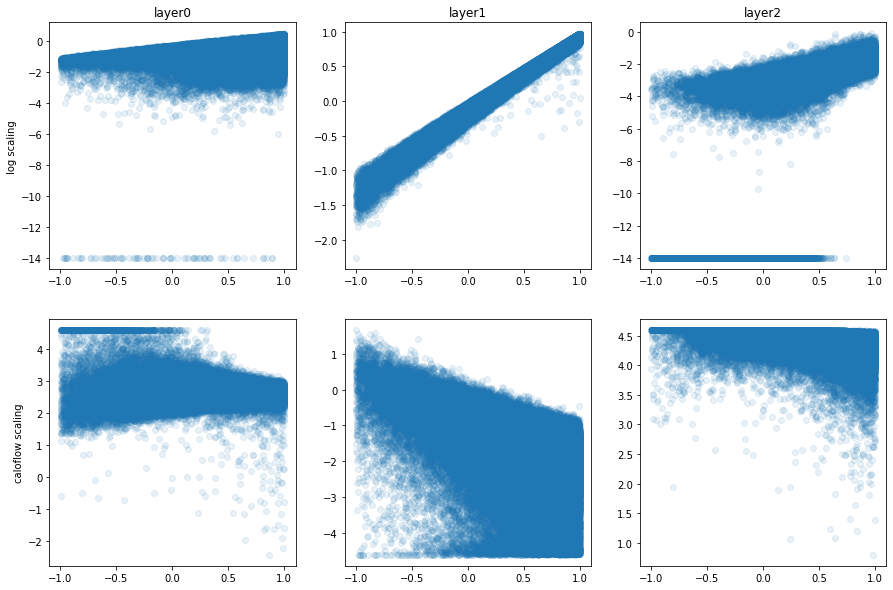

In [71]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.scatter(data_log[:,3], data_log[:,0], alpha=0.1)
plt.title("layer0")
plt.ylabel("log scaling")
plt.subplot(232)
plt.scatter(data_log[:,3], data_log[:,1], alpha=0.1)
plt.title("layer1")
plt.subplot(233)
plt.scatter(data_log[:,3], data_log[:,2], alpha=0.1)
plt.title("layer2")
plt.subplot(234)
plt.scatter(data_caloflow[:,3], data_caloflow[:,0], alpha=0.1)
plt.ylabel("caloflow scaling")
plt.subplot(235)
plt.scatter(data_caloflow[:,3], data_caloflow[:,1], alpha=0.1)
plt.subplot(236)
plt.scatter(data_caloflow[:,3], data_caloflow[:,2], alpha=0.1)

In [7]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord-photon-sampling-old-scaling",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord-photon-sampling-old-scaling",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [15]:
LR = 1e-2
NUM_EPOCHS = 100
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 30*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

BATCH_SIZE = 20000

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
]
    
#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history = model.fit(
    data_caloflow,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

Number of trainable params: 45015
Number of nontrainable params: 2.0
Number of total params: 45017.0
Epoch 1/100
9/9 [==============================] - 82s 2s/step - loss: 21.2693 - val_loss: 13.6036 - lr: 0.0100
Epoch 2/100
9/9 [==============================] - 8s 872ms/step - loss: 9.1200 - val_loss: 6.0016 - lr: 0.0100
Epoch 3/100
9/9 [==============================] - 8s 884ms/step - loss: 5.2942 - val_loss: 4.5887 - lr: 0.0100
Epoch 4/100
9/9 [==============================] - 8s 900ms/step - loss: 4.4323 - val_loss: 3.9999 - lr: 0.0100
Epoch 5/100
9/9 [==============================] - 8s 868ms/step - loss: 3.8446 - val_loss: 3.5924 - lr: 0.0100
Epoch 6/100
9/9 [==============================] - 8s 876ms/step - loss: 3.4716 - val_loss: 4.8164 - lr: 0.0100
Epoch 7/100
9/9 [==============================] - 8s 870ms/step - loss: 3.7115 - val_loss: 3.3868 - lr: 0.0100
Epoch 8/100
9/9 [==============================] - 8s 921ms/step - loss: 3.1935 - val_loss: 2.9952 - lr: 0.0100
Epo

In [73]:
min(history.history['val_loss'])

-2.203829765319824

In [16]:
save_model(model, name="ffjord-photon-sampling-alpha1e-6-45015")

In [17]:
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 30*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions
BATCH_SIZE = 20000

stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='exact',name='loaded_model')
load_model(model, name='ffjord-photon-sampling-alpha1e-6-45015')

In [22]:
def plot_hist_3_layers(layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(18, 4))
    plt.subplot(131)    
    plt.hist(layer0, bins=np.linspace(0,25000,21), label='actual')
    plt.hist(layer0_sampled, bins=np.linspace(0,25000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 0 energy (MeV)')
    plt.legend()
    plt.subplot(132)    
    plt.hist(layer1, bins=np.linspace(0,100000,21), label='actual')
    plt.hist(layer1_sampled, bins=np.linspace(0,100000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 1 energy (MeV)')
    plt.legend()
    plt.subplot(133)    
    plt.hist(layer2, bins=np.linspace(0,2000,21), label='actual')
    plt.hist(layer2_sampled, bins=np.linspace(0,2000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 2 energy (MeV)')
    plt.legend()
    
def plot_scat_layers_v_tot(energy, layer0, layer1, layer2, \
                           layer0_sampled, layer1_sampled, layer2_sampled, \
                           max0, max1, max2):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.scatter(energy, layer0, label='actual')
    plt.legend()
    plt.subplot(232)
    plt.scatter(energy, layer1, label='actual')
    plt.subplot(233)
    plt.scatter(energy, layer2, label='actual')
    plt.subplot(234)
    plt.scatter(energy, layer0_sampled, color='orange', label='learned')
    plt.ylim(0,max0)
    plt.legend()
    plt.subplot(235)
    plt.scatter(energy, layer1_sampled, color='orange', label='learned')
    plt.ylim(0,max1)
    plt.subplot(236)
    plt.scatter(energy, layer2_sampled, color='orange', label='learned')
    plt.ylim(0,max2)
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('energy in each layer (MeV)')

def plot_sum_v_tot(energy, layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.scatter(energy*1000, layer0+layer1+layer2, label='actual')
    plt.legend()
    plt.subplot(122)
    plt.scatter(energy*1000, layer0_sampled + layer1_sampled + layer2_sampled, color='orange', label='learned')
    plt.ylim(0,100000)
    plt.legend()
    fig.supxlabel('total energy (MeV)')
    fig.supylabel('energy in all layers (MeV)')

def plot_avg_v_tot(avg0_true, avg1_true, avg2_true, avg0_sampled, avg1_sampled, avg2_sampled):
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.plot(np.linspace(5,100,20), avg0_true, label='actual')
    plt.plot(np.linspace(5,100,20), avg0_sampled, c='orange', label='learned')
    plt.legend()
    plt.subplot(132)
    plt.plot(np.linspace(5,100,20), avg1_true)
    plt.plot(np.linspace(5,100,20), avg1_sampled, c='orange')
    plt.subplot(133)
    plt.plot(np.linspace(5,100,20), avg2_true)
    plt.plot(np.linspace(5,100,20), avg2_sampled, c='orange')
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('average energy in each layer (GeV)')

In [80]:
def postprocess_caloflow(samples, en, alpha):
    v0 = samples[:,0]
    v1 = samples[:,1]
    v2 = samples[:,2]
    x0 = np.exp(v0)/(np.exp(v0) + 1)
    x1 = np.exp(v1)/(np.exp(v1) + 1)
    x2 = np.exp(v2)/(np.exp(v2) + 1)
    u0 = (alpha - x0)/(2*alpha - 1)
    u1 = (alpha - x1)/(2*alpha - 1)
    u2 = (alpha - x2)/(2*alpha - 1)

    e_mev = en*1000
    layer0_sampled = u0 * u1 *e_mev
    layer1_sampled = u0 * (1-u1) * u2 * e_mev
    layer2_sampled = u0 * (1-u1) * (1-u2) * e_mev
    return layer0_sampled, layer1_sampled, layer2_sampled

In [81]:
energy_scaled = data_log[:,-1].reshape((N,1))

#Sample the learned distribution
samples_with_energy = model.flow.sample(
    N,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': energy_scaled}})
)

samples_scaled = np.concatenate([samples_with_energy, energy_scaled],-1)
samples_expd = 10**samples_scaled * 10000
layer0_sampled = samples_expd[:,0]
layer1_sampled = samples_expd[:,1]
layer2_sampled = samples_expd[:,2]

In [20]:
energy_scaled = data_caloflow[:,-1].reshape((N,1))

#Sample the learned distribution
u_samples = model.flow.sample(
    N,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': energy_scaled}})
)

layer0_sampled, layer1_sampled, layer2_sampled = postprocess_caloflow(u_samples, energy.reshape(N,), alpha)

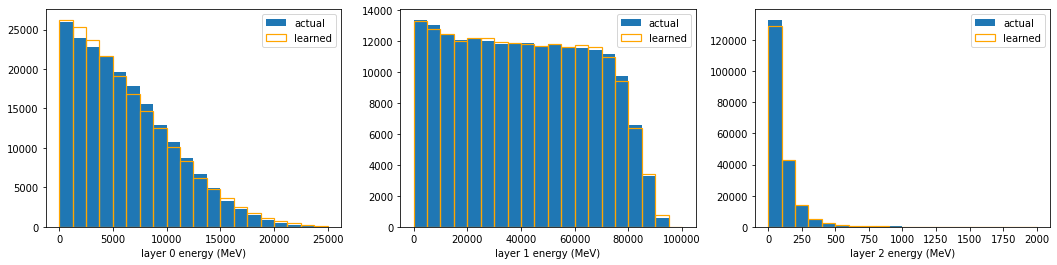

In [23]:
plot_hist_3_layers(layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled)

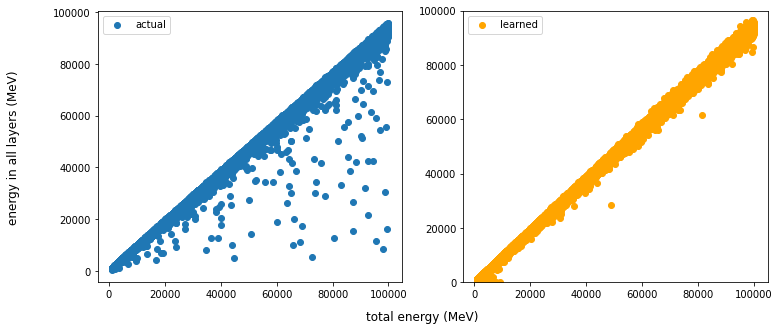

In [24]:
plot_sum_v_tot(energy, layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled)

(array([1.1000e+01, 1.4000e+01, 1.3000e+01, 1.7000e+01, 2.2000e+01,
        2.3000e+01, 3.7000e+01, 3.1000e+01, 6.1000e+01, 5.0000e+01,
        6.9000e+01, 8.2000e+01, 1.2500e+02, 1.4500e+02, 1.7700e+02,
        2.6200e+02, 3.5500e+02, 4.5000e+02, 6.2800e+02, 9.4100e+02,
        1.4940e+03, 2.5360e+03, 4.5210e+03, 8.7200e+03, 1.6834e+04,
        2.8431e+04, 3.7339e+04, 3.6258e+04, 2.6335e+04, 1.5292e+04,
        7.8310e+03, 4.0070e+03, 2.3040e+03, 1.3680e+03, 8.6200e+02,
        5.8800e+02, 3.8100e+02, 2.6000e+02, 2.3400e+02, 1.8000e+02,
        1.2100e+02, 1.0300e+02, 6.6000e+01, 5.9000e+01, 4.1000e+01,
        3.7000e+01, 2.4000e+01, 2.3000e+01, 2.8000e+01]),
 array([0.8       , 0.80510204, 0.81020408, 0.81530612, 0.82040816,
        0.8255102 , 0.83061224, 0.83571429, 0.84081633, 0.84591837,
        0.85102041, 0.85612245, 0.86122449, 0.86632653, 0.87142857,
        0.87653061, 0.88163265, 0.88673469, 0.89183673, 0.89693878,
        0.90204082, 0.90714286, 0.9122449 , 0.91734694, 0.

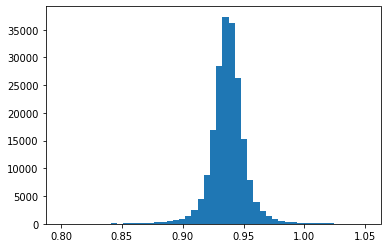

In [30]:
plt.hist((layer0+layer1+layer2)/(energy*1000).reshape(N,),bins=np.linspace(0.8, 1.05, 50))

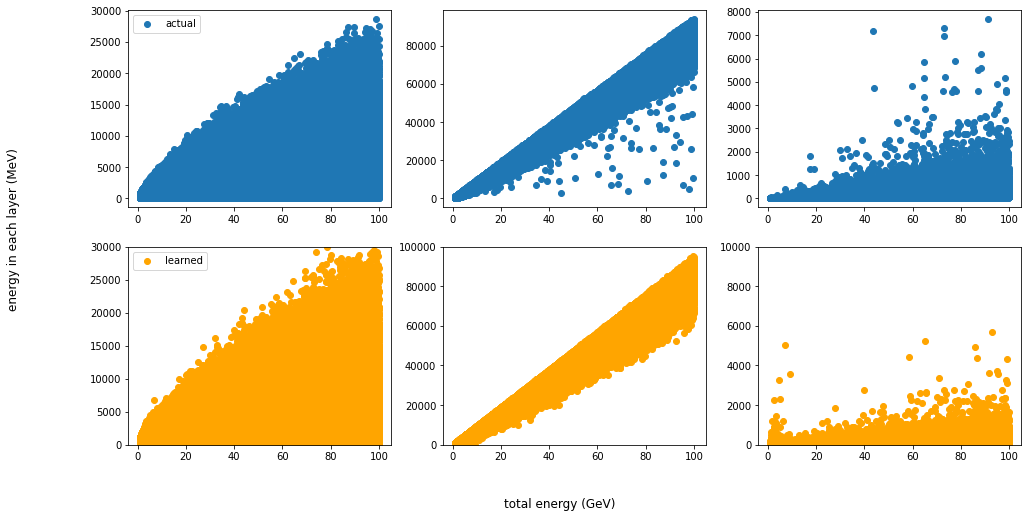

In [25]:
plot_scat_layers_v_tot(energy, layer0, layer1, layer2, \
                           layer0_sampled, layer1_sampled, layer2_sampled, \
                           30000, 100000, 10000)

In [ ]:
energy_range = range(5, 105, 5)
photon_avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conditionals = np.full((N,1), e)
    conditionals = np.log10(conditionals/10)
    photon_samples = model.flow.sample(
        N,
        bijector_kwargs=make_bijector_kwargs(
            model.flow.bijector, {'bijector.': {'conditional_input': conditionals}})
    )
    photon_samples_scaled_back = 10**photon_samples * 10000
    avg0 = np.mean(photon_samples_scaled_back[:,0])
    avg1 = np.mean(photon_samples_scaled_back[:,1])
    avg2 = np.mean(photon_samples_scaled_back[:,2])
    photon_avg_layer_energies.append([avg0, avg1, avg2])

photon_avg_energies = np.array(photon_avg_layer_energies)
photon_avg0_sampled = photon_avg_energies[:,0]
photon_avg1_sampled = photon_avg_energies[:,1]
photon_avg2_sampled = photon_avg_energies[:,2]

photon_all_energies = np.concatenate([energy_layer, energy], -1)
photon_avg_layer_energies_true = []

for e in energy_range:
    selected_rows = photon_all_energies[(photon_all_energies[:,3] >= e-5) & (photon_all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    photon_avg_layer_energies_true.append([avg0, avg1, avg2])

photon_avg_energies_true = np.array(photon_avg_layer_energies_true)
photon_avg0_true = photon_avg_energies_true[:,0]
photon_avg1_true = photon_avg_energies_true[:,1]
photon_avg2_true = photon_avg_energies_true[:,2]

plot_avg_v_tot(photon_avg0_true, photon_avg1_true, photon_avg2_true, \
               photon_avg0_sampled, photon_avg1_sampled, photon_avg2_sampled)

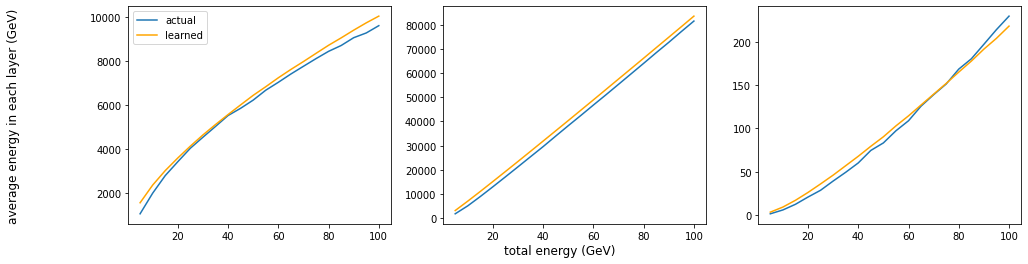

In [26]:
# CaloFlow scaling 2.0
energy_range = range(5, 105, 5)
avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conditionals = np.full((N,1), e)
    conds_log = np.log10(conditionals/10)
    samples = model.flow.sample(
        N,
        bijector_kwargs=make_bijector_kwargs(
            model.flow.bijector, {'bijector.': {'conditional_input': conds_log}})
    )
    layer0_sampled, layer1_sampled, layer2_sampled = postprocess_caloflow(samples, conditionals.reshape(N,), alpha)
    avg0 = np.mean(layer0_sampled)
    avg1 = np.mean(layer1_sampled)
    avg2 = np.mean(layer2_sampled)
    avg_layer_energies.append([avg0, avg1, avg2])

avg_energies = np.array(avg_layer_energies)
avg0_sampled = avg_energies[:,0]
avg1_sampled = avg_energies[:,1]
avg2_sampled = avg_energies[:,2]

all_energies = np.concatenate([energy_layer, energy], -1)
avg_layer_energies_true = []

for e in energy_range:
    selected_rows = all_energies[(all_energies[:,3] >= e-5) & (all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    avg_layer_energies_true.append([avg0, avg1, avg2])

avg_energies_true = np.array(avg_layer_energies_true)
avg0_true = avg_energies_true[:,0]
avg1_true = avg_energies_true[:,1]
avg2_true = avg_energies_true[:,2]

plot_avg_v_tot(avg0_true, avg1_true, avg2_true, \
               avg0_sampled, avg1_sampled, avg2_sampled)

In [78]:
def jacobian(v0, v1, v2, Etot, alpha):
    return -(np.exp(v0+v1+v2) * (alpha + (alpha-1)*np.exp(v0))**2 * (alpha*np.exp(v1)+alpha-1) * Etot**3)/\
            ((1-2*alpha)**6 * (1+np.exp(v0))**4 * (1+np.exp(v1))**3 * (1+np.exp(v2))**2)

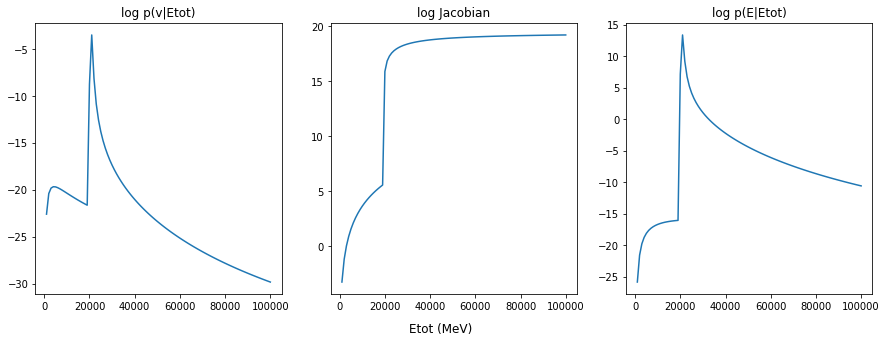

In [99]:
def plot_likelihood(model, unscaled_point, N, alpha):
    e0, e1, e2 = unscaled_point
    etots = np.linspace(1000, 100000, N)
    zs = np.log10(etots/10000).reshape((N,1))
    points, jacs = [], []
    for z in zs:
        etot = 10 ** z[0] * 10
        data = preprocess_caloflow(1, np.array([e0]), np.array([e1]), np.array([e2]), np.array([[etot]]), alpha)
        v0, v1, v2 = data[0][0], data[0][1], data[0][2]
        en = np.array([v0, v1, v2])
        points.append(en)
        jac = jacobian(v0, v1, v2, etot*1000, alpha)
        jacs.append(jac)
    points = np.array(points).astype(np.float32)
    log_probs = model.conditional_log_prob(points, zs)
    actual_log_probs = np.array(log_probs) + np.log(np.array(jacs))
    #print(jacs)
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(10**zs*10000, log_probs)
    plt.title("log p(v|Etot)")
    plt.subplot(132)
    plt.plot(10**zs*10000, np.log(jacs))
    plt.title("log Jacobian")
    plt.subplot(133)
    plt.plot(10**zs*10000, actual_log_probs)
    plt.title("log p(E|Etot)")
    fig.supxlabel("Etot (MeV)")

i = 2048
e0, e1, e2 = layer0[i], layer1[i], layer2[i]
en = np.array([e0, e1, e2])
plot_likelihood(model, en, 100, alpha)

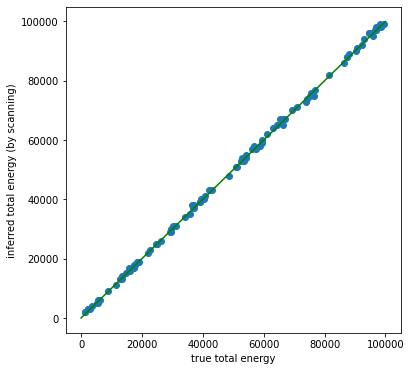

In [94]:
def scanner_caloflow(model, unscaled_point, N, alpha):
    e0, e1, e2 = unscaled_point
    etots = np.linspace(1000, 100000, N)
    zs = np.log10(etots/10000).reshape((N,1))
    points, jacs = [], []
    for z in zs:
        etot = 10 ** z[0] * 10
        data = preprocess_caloflow(1, np.array([e0]), np.array([e1]), np.array([e2]), np.array([[etot]]), alpha)
        v0, v1, v2 = data[0][0], data[0][1], data[0][2]
        en = np.array([v0, v1, v2])
        points.append(en)
        jac = jacobian(v0, v1, v2, etot*1000, alpha)
        jacs.append(jac)
    points = np.array(points).astype(np.float32)
    log_probs = model.conditional_log_prob(points, zs)
    actual_log_probs = np.array(log_probs) + np.log(np.array(jacs))
    max_index = np.argmax(actual_log_probs)
    c_max = zs[max_index][0]
    return c_max

true_ens = []
inferred_ens = []
for j in range(100):
    i = np.random.randint(200000)
    e0, e1, e2 = layer0[i], layer1[i], layer2[i]
    en = np.array([e0, e1, e2])
    c_max = scanner_caloflow(model, en, 100, alpha)
    ans = 10 ** c_max * 10000
    true_ens.append(energy[i][0]*1000)
    inferred_ens.append(ans)

fig = plt.figure(figsize=(6,6))
plt.scatter(true_ens, inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")

plt.plot([0,50000,100000], [0,50000,100000], c='green')

Text(0, 0.5, 'resolution ( std/average true energy )')

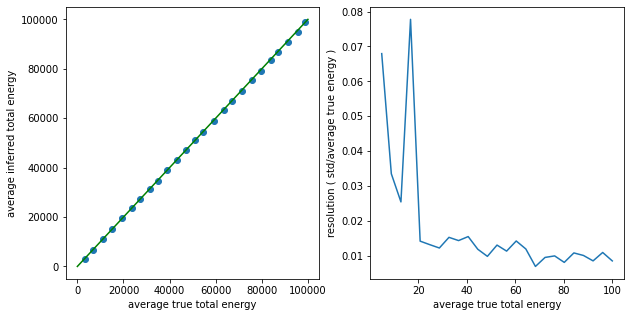

In [119]:
energy_layer = np.stack([layer0, layer1, layer2], -1)
all_energies = np.concatenate([energy_layer, energy],-1)

energy_range = range(5,104,4)
true_avgs, inf_avgs, stds = [], [], []
for e in energy_range:
    selected_rows = all_energies[(all_energies[:,3] >= e-4) & (all_energies[:,3] <=e)]
    n_rows = selected_rows.shape[0]
    true_ens = []
    inferred_ens = []
    n_trials = 20
    for i in range(n_trials):
        j = np.random.randint(n_rows)
        e0, e1, e2 = selected_rows[j][0], selected_rows[j][1], selected_rows[j][2]
        en = np.array([e0, e1, e2])
        c_max = scanner_caloflow(model, en, 250, alpha)
        ans = 10 ** c_max * 10000
        true_ens.append(selected_rows[j][3]*1000)
        inferred_ens.append(ans)
    std = np.sqrt(sum((np.array(inferred_ens) - np.array(true_ens)) ** 2)/n_trials)
    true_avgs.append(np.mean(inferred_ens))
    inf_avgs.append(np.mean(true_ens))
    stds.append(std)

true_avgs = np.array(true_avgs)
stds = np.array(stds)
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(true_avgs, inf_avgs)
plt.xlabel("average true total energy")
plt.ylabel("average inferred total energy")
plt.plot([0,50000,100000], [0,50000,100000], c='green')
plt.subplot(122)
plt.plot(np.linspace(5,100,25), stds/true_avgs)
plt.xlabel("average true total energy")
plt.ylabel("resolution ( std/average true energy )")

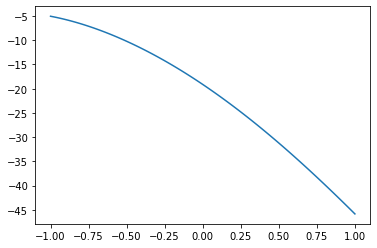

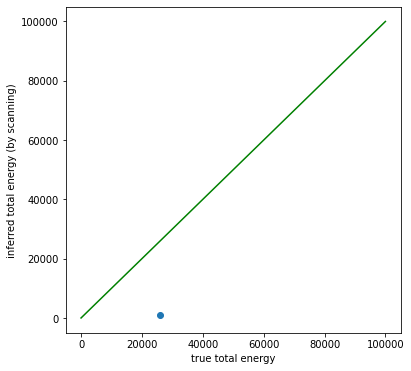

In [32]:
def scanner_log(model, point, N, min_range, max_range):
    points = np.array([point] * (N+1))
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    zs = zs * (max_range - min_range) + min_range
    log_probs = model.conditional_log_prob(points, zs)
    #plt.plot(zs, log_probs)
    #max_prob = np.amax(log_probs)
    max_index = np.argmax(log_probs)
    #c_max = max_index / N
    c_max = zs[max_index][0]
    return c_max

true_ens = []
inferred_ens = []
for j in range(100):
    i = np.random.randint(200000)
    e0, e1, e2 = layer0[i], layer1[i], layer2[i]
    en = np.array([e0, e1, e2]).astype(np.float32)
    en += 1e-10
    en = np.log10(en/10000)
    c_max = scanner_log(model, en, 100, -1, 1)
    ans = 10 ** c_max * 10000
    true_ens.append(energy[i][0]*1000)
    inferred_ens.append(ans)

fig = plt.figure(figsize=(6,6))
plt.scatter(true_ens, inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")
plt.plot([0,50000,100000], [0,50000,100000], c='green')

## DEFUNCT

In [ ]:
def sample_and_scale(N, model, scaler_data, scaler_cond, conds):
    conds_log = np.log10(conds/10)
    conds_scaled = scaler_cond.transform(conds_log.reshape(-1,1))
    samples = model.flow.sample(
        N,
        bijector_kwargs=make_bijector_kwargs(
            model.flow.bijector, {'bijector.': {'conditional_input': conds_scaled}})
    )
    samples_scaled_back = scaler_data.inverse_transform(samples)
    u0_sampled = samples_scaled_back[:,0]
    u1_sampled = samples_scaled_back[:,1]
    u2_sampled = samples_scaled_back[:,2]
    cond_mev = conds*1000
    cond_mev = cond_mev.reshape(N,)
    layer0_sampled = u1_sampled*u0_sampled*cond_mev
    layer1_sampled = u2_sampled*(1-u1_sampled)*u0_sampled*cond_mev
    layer2_sampled = (1-u1_sampled)*(1-u2_sampled)*u0_sampled*cond_mev
    return layer0_sampled, layer1_sampled, layer2_sampled

layer0_sampled, layer1_sampled, layer2_sampled = sample_and_scale(N, model, scaler_data, scaler_cond, energy)

In [ ]:
energy_range = range(5, 105, 5)
avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conds = np.full((N,1), e)
    layer0_sampled, layer1_sampled, layer2_sampled = sample_and_scale(N, model, scaler_data, scaler_cond, conds)
    avg0 = np.mean(layer0_sampled)
    avg1 = np.mean(layer1_sampled)
    avg2 = np.mean(layer2_sampled)
    avg_layer_energies.append([avg0, avg1, avg2])

avg_energies = np.array(avg_layer_energies)
avg0_sampled = avg_energies[:,0]
avg1_sampled = avg_energies[:,1]
avg2_sampled = avg_energies[:,2]

all_energies = np.concatenate([energy_layer, energy], -1)
avg_layer_energies_true = []

for e in energy_range:
    selected_rows = all_energies[(all_energies[:,3] >= e-5) & (all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    avg_layer_energies_true.append([avg0, avg1, avg2])

avg_energies_true = np.array(avg_layer_energies_true)
avg0_true = avg_energies_true[:,0]
avg1_true = avg_energies_true[:,1]
avg2_true = avg_energies_true[:,2]

plot_avg_v_tot(avg0_true, avg1_true, avg2_true, avg0_sampled, avg1_sampled, avg2_sampled)

In [ ]:
def scanner_stdsclr(model, scaler_data, scaler_cond, point, N, min_range, max_range):
    points = np.array([point] * (N+1))
    #print(points.shape)
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    zs = zs * (max_range - min_range) + min_range
    #print(points.shape)
    log_probs = model.conditional_log_prob(points, zs)
    max_index = np.argmax(log_probs)
    c_max = zs[max_index]
    c_max_scaled_back = scaler_cond.inverse_transform(np.array([c_max]))[0][0]
    ans = 10 ** c_max_scaled_back * 10
    return ans

true_ens = []
inferred_ens = []
for j in range(100):
    i = np.random.randint(200000)
    e0, e1, e2, etot = data_train[i] # already scaled
    en = np.array([e0, e1, e2]).astype(np.float32)
    ans = scanner(model, scaler_data, scaler_cond, en, 100, -4, 1)
    true_ens.append(energy[i][0])
    inferred_ens.append(ans)

fig = plt.figure(figsize=(6,6))
plt.scatter(true_ens, inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")
plt.plot([0,50,100], [0,50,100], c='green')